# Results 2b: Similarity Analysis

In [1]:
import os
import numpy as np
from pandas import read_csv
from tqdm import tqdm

## Load reject data.
metrics = read_csv(os.path.join('data','metrics.csv'))

## Section 1: Proportion of Participants Flagged 

#### 1.1 Accuracy

```python
from scipy.stats import binom_test
binom_test(38, n=90, p=0.33, alternative='greater')
```

In [2]:
from statsmodels.stats.proportion import proportions_ztest

## Perform 2-sample proportion test on platform.
zval, pval = proportions_ztest([18, 8], [186, 200])
print('z = %0.3f, p = %0.3f' %(zval, pval))

## Tally failing participants.
metrics.groupby('platform').accuracy.agg(
    mean = lambda x: (x < 0.38).mean(),
    sum = lambda x: (x <0.38).sum(),
    count = lambda x: x.size
).round(2)

z = 2.224, p = 0.026


,mean,sum,count
platform,,,
mturk,0.10,18.0,186.0
prolific,0.04,8.0,200.0


#### 2.2 Infrequency Items

In [3]:
from statsmodels.stats.proportion import proportions_ztest

## Perform 2-sample proportion test on platform.
zval, pval = proportions_ztest([50, 35], [186, 200])
print('z = %0.3f, p = %0.3f' %(zval, pval))

## Tally failing participants.
metrics.groupby('platform').infreq.agg(
    mean = lambda x: (x > 0).mean(),
    sum = lambda x: (x > 0).sum(),
    count = lambda x: x.size
).round(2)

z = 2.223, p = 0.026


,mean,sum,count
platform,,,
mturk,0.27,50,186
prolific,0.18,35,200


## Section 2: Metric Correspondence

In [4]:
## Define variables of interest.
cols = ['infreq','isd','reliability','mahalanobis','survey_rt','variability','accuracy','wsls','task_rt']

## Precompute lower triangular indices.
ix = np.tril_indices(len(cols), k=-1)

## Precompute space for results.
tril = np.zeros((ix[0].size, 3))
fwer = np.zeros((ix[0].size, 3))

#### 3.1 Monotonic Dependence (Unthresholded)

In [5]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define number of permutations.
n_iter = 5000

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Permutation testing.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)

## Compute and store true lower diagonal.
tril[:,0] = metrics[cols].corr(method='spearman').values[ix]

## Preallocate space.
max_rho = np.zeros(n_iter)

## Main loop.
for i in tqdm(range(n_iter)):
    
    ## Permute DataFrame.
    permuted = metrics[cols].apply(np.random.permutation).copy()
    
    ## Compute correlation matrix.
    permuted = permuted.corr(method='spearman').values[ix]
    
    ## Store.
    max_rho[i] = np.abs(permuted).max()
    
## Compute adjusted p-values.
fwer[:,0] = ((np.abs(tril[:,0]) <= max_rho[:,np.newaxis]).sum(axis=0) + 1) / (n_iter + 1)

100%|██████████| 5000/5000 [00:21<00:00, 237.48it/s]


#### 3.2 Rejection Similarity (Thresohold = 25%) 

In [6]:
from scipy.spatial.distance import dice

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define quantile.
q = 0.25

## Define number of permutations.
n_iter = 5000

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Threshold parameters. 
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Copy reject DataFrame.
thresh = metrics[cols].copy()

## Threshold variables.
thresh['infreq'] = np.where( thresh['infreq'] > 0, 1, 0 )
thresh['isd'] = np.where( thresh['isd'] > thresh['isd'].quantile(1-q), 1, 0 )
thresh['reliability'] = np.where( thresh['reliability'] < thresh['reliability'].quantile(q), 1, 0 )
thresh['mahalanobis'] = np.where( thresh['mahalanobis'] > thresh['mahalanobis'].quantile(1-q), 1, 0 )
thresh['survey_rt'] = np.where( thresh['survey_rt'] < thresh['survey_rt'].quantile(q), 1, 0 )
thresh['variability'] = np.where( thresh['variability'] > thresh['variability'].quantile(1-q), 1, 0 )
thresh['accuracy'] = np.where( thresh['accuracy'] < thresh['accuracy'].quantile(q), 1, 0 )
thresh['wsls'] = np.where( thresh['wsls'] < thresh['wsls'].quantile(q), 1, 0 )
thresh['task_rt'] = np.where( thresh['task_rt'] > thresh['task_rt'].quantile(1-q), 1, 0 )

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Permutation testing.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)

## Compute and store true lower diagonal.
tril[:,1] = 1 - thresh[cols].corr(method=dice).values[ix]

## Preallocate space.
max_rho = np.zeros(n_iter)

## Main loop.
for i in tqdm(range(n_iter)):
    
    ## Permute DataFrame.
    permuted = thresh[cols].apply(np.random.permutation).copy()
    
    ## Compute correlation matrix.
    permuted = 1 - permuted.corr(method=dice).values[ix]
    
    ## Store.
    max_rho[i] = np.abs(permuted).max()
    
## Compute adjusted p-values.
fwer[:,1] = ((np.abs(tril[:,1]) <= max_rho[:,np.newaxis]).sum(axis=0) + 1) / (n_iter + 1)

100%|██████████| 5000/5000 [00:28<00:00, 178.05it/s]


#### 3.3 Rejection Similarity (Thresohold = 10%) 

In [7]:
from scipy.spatial.distance import dice

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define quantile.
q = 0.10

## Define number of permutations.
n_iter = 5000

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Threshold parameters. 
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Copy reject DataFrame.
thresh = metrics[cols].copy()

## Threshold variables.
thresh['infreq'] = np.where( thresh['infreq'] > 0, 1, 0 )
thresh['isd'] = np.where( thresh['isd'] > thresh['isd'].quantile(1-q), 1, 0 )
thresh['reliability'] = np.where( thresh['reliability'] < thresh['reliability'].quantile(q), 1, 0 )
thresh['mahalanobis'] = np.where( thresh['mahalanobis'] > thresh['mahalanobis'].quantile(1-q), 1, 0 )
thresh['survey_rt'] = np.where( thresh['survey_rt'] < thresh['survey_rt'].quantile(q), 1, 0 )
thresh['variability'] = np.where( thresh['variability'] > thresh['variability'].quantile(1-q), 1, 0 )
thresh['accuracy'] = np.where( thresh['accuracy'] < thresh['accuracy'].quantile(q), 1, 0 )
thresh['wsls'] = np.where( thresh['wsls'] < thresh['wsls'].quantile(q), 1, 0 )
thresh['task_rt'] = np.where( thresh['task_rt'] > thresh['task_rt'].quantile(1-q), 1, 0 )

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Permutation testing.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)

## Compute and store true lower diagonal.
tril[:,2] = 1 - thresh[cols].corr(method=dice).values[ix]

## Preallocate space.
max_rho = np.zeros(n_iter)

## Main loop.
for i in tqdm(range(n_iter)):
    
    ## Permute DataFrame.
    permuted = thresh[cols].apply(np.random.permutation).copy()
    
    ## Compute correlation matrix.
    permuted = 1 - permuted.corr(method=dice).values[ix]
    
    ## Store.
    max_rho[i] = np.abs(permuted).max()
    
## Compute adjusted p-values.
fwer[:,2] = ((np.abs(tril[:,2]) <= max_rho[:,np.newaxis]).sum(axis=0) + 1) / (n_iter + 1)

100%|██████████| 5000/5000 [00:31<00:00, 157.74it/s]


## Section 3: Plotting

#### 3.1 Main Figure

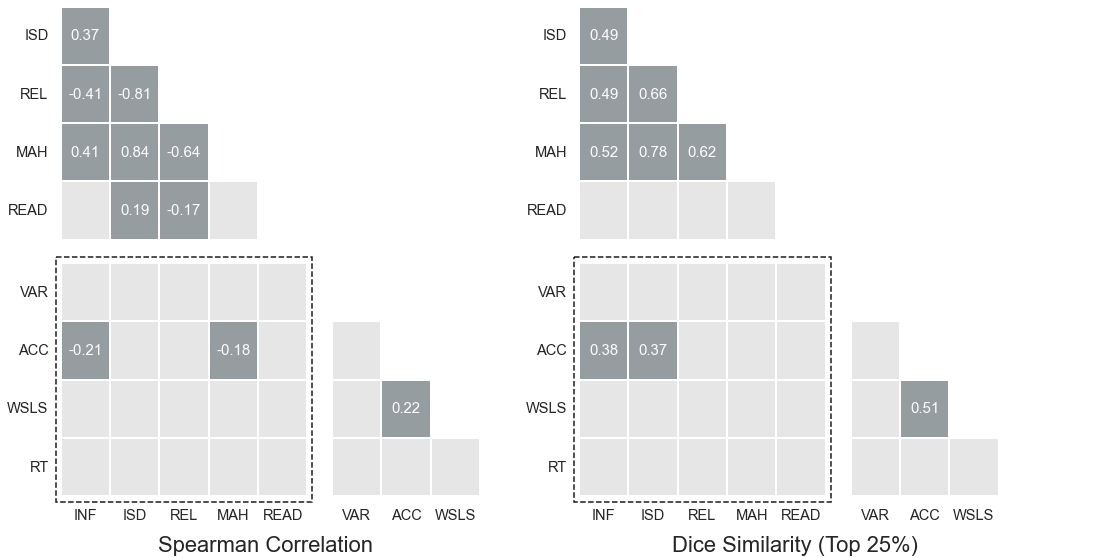

In [8]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
sns.set_theme('notebook', style='white', font='sans-serif', font_scale=1.33)
%matplotlib inline

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define canvas.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig = plt.figure(figsize=(16,8))
                         
## Initialize grid.
gs = fig.add_gridspec(nrows=1, ncols=2, left=0.05, right=0.95, top=0.95, bottom=0.10, wspace=0.0, hspace=0.0)

## Initialize panels.
left_panel  = gs[0].subgridspec(nrows=2, ncols=2, wspace=0.1, hspace=0.1)
right_panel = gs[1].subgridspec(nrows=2, ncols=2, wspace=0.1, hspace=0.1)

## Define features.
cmap = ListedColormap(['#de425b','0.9','#959da1'])
titles = ['Spearman Correlation', 'Dice Similarity (Top 25%)']
annot_color = '0.99'
labelpad = 6

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

for k, panel in enumerate([left_panel, right_panel]):

    ## Initialize correlation matrix.
    corr = np.zeros((8,10))
    corr[np.tril_indices_from(corr, k=0)] = np.where(fwer[:,k] < 0.05, tril[:,k], 0)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Self-report correlations.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

    ## Initialize axis.
    ax = plt.subplot(panel[0,0])

    ## Plot correlations.
    arr = corr[:4,:5]
    sns.heatmap(np.abs(np.sign(arr)), cmap=cmap, cbar=False, center=0, linecolor='w', linewidths=1, 
                xticklabels=[], mask=np.triu(np.ones_like(arr), k=1), ax=ax)

    ## Add annotations.
    for i, j in np.array(np.where(arr)).T:
        ax.text(j+0.5, i+0.5, '%0.2f' %arr[i,j], ha='center', va='center', fontsize=15, color=annot_color)

    ## Add labels.
    yticklabels = ['ISD','REL','MAH','READ'] # if not k else ['','','','']
    ax.set_yticklabels(yticklabels, rotation=0, ha='right', va='center')
    ax.tick_params(axis='both', which='major', pad=labelpad)
        
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Joint correlations.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

    ## Initialize axis.
    ax = plt.subplot(panel[1,0])

    ## Plot correlations.
    arr = corr[4:,:5]
    sns.heatmap(np.abs(np.sign(arr)), cmap=cmap, cbar=False, center=0, linecolor='w', linewidths=1, ax=ax)

    ## Add annotations.
    for i, j in np.array(np.where(arr)).T:
        ax.text(j+0.5, i+0.5, '%0.2f' %arr[i,j], ha='center', va='center', fontsize=15, color=annot_color)

    ## Add labels.
    yticklabels = ['VAR','ACC','WSLS','RT'] # if not k else ['','','','']
    ax.set_yticklabels(yticklabels, rotation=0, ha='right', va='center')
    ax.set_xticklabels(['INF','ISD','REL','MAH','READ'], rotation=0, ha='center', va='top')
    ax.tick_params(axis='both', which='major', pad=labelpad)
    
    ## Add border.
    border = Rectangle((-0.1,-0.1), 5.2, 4.2, fill=False, linewidth=1.5, linestyle='--', edgecolor='k')
    border = ax.add_patch(border)
    border.set_clip_on(False)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Task correlations.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

    ## Initialize axis.
    ax = plt.subplot(panel[1,1])

    ## Plot correlations.
    arr = corr[4:,5:]
    sns.heatmap(np.abs(np.sign(arr)), cmap=cmap, cbar=False, center=0, linecolor='w', linewidths=1,
                yticklabels=[], mask=np.triu(np.ones_like(arr), k=0), ax=ax)

    ## Add annotations.
    for i, j in np.array(np.where(arr)).T:
        ax.text(j+0.5, i+0.5, '%0.2f' %arr[i,j], ha='center', va='center', fontsize=15, color=annot_color)

    ## Add labels.
    ax.set_xticklabels(['VAR','ACC','WSLS','',''], rotation=0, ha='center', va='top')
    ax.tick_params(axis='both', which='major', pad=labelpad)
    
    ## Add title.
    ax.annotate(titles[k], (0,0), (0.24 if not k else 0.72, 0.04), xycoords='figure fraction', 
                fontsize=22, ha='center', va='top')
    
## Save figure.
plt.savefig(os.path.join('..','figures','main_02b.png'), dpi=180, transparent=True)

#### 3.2 Supplementary Tables

In [9]:
from pandas import DataFrame

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define tables.
tables = ['Spearman Correlation', 'Dice Similarity (Top 25%)', 'Dice Similarity (Top 10%)']

## Define columns.
columns = ['INF','ISD','REL','MAH','READ','VAR','ACC','WSLS','RT']

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

for i, table in enumerate(tables):
    print(f'Constructing Table {i+1}: {table}.')

    ## Initialize correlation matrix.
    corr = np.identity(len(columns))
    corr = np.where(corr, '-', '').astype('<U16')

    ## Add lower diagonal elements.
    fmt = lambda r, p: '%0.3f*' %r if p < 0.05 else '%0.3f' %r
    corr[ix] = [fmt(r,p) for r, p in zip(tril[:,i], fwer[:,i])]

    ## Convert to DataFrame.
    corr = DataFrame(corr, index=columns, columns=columns)

    ## Print LaTeX.
    print(corr.to_latex())

Constructing Table 1: Spearman Correlation.
\begin{tabular}{llllllllll}
\toprule
{} &      INF &      ISD &      REL &      MAH &    READ &     VAR &     ACC &   WSLS & RT \\
\midrule
INF  &        - &          &          &          &         &         &         &        &    \\
ISD  &   0.372* &        - &          &          &         &         &         &        &    \\
REL  &  -0.408* &  -0.811* &        - &          &         &         &         &        &    \\
MAH  &   0.406* &   0.843* &  -0.643* &        - &         &         &         &        &    \\
READ &   -0.111 &   0.193* &  -0.168* &    0.138 &       - &         &         &        &    \\
VAR  &   -0.061 &   -0.029 &    0.058 &   -0.024 &  -0.026 &       - &         &        &    \\
ACC  &  -0.206* &   -0.154 &    0.099 &  -0.182* &  -0.074 &   0.027 &       - &        &    \\
WSLS &    0.060 &    0.102 &   -0.089 &    0.115 &   0.103 &  -0.060 &  0.221* &      - &    \\
RT   &    0.040 &   -0.019 &    0.014 &    0.013